<a href="https://colab.research.google.com/github/Pager07/TensorflowSpecialization/blob/master/C4W2_TimeSeriesUsingSingleDense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#Creating Series data (given)

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


 What does shuffle buffer do?
 - if you have 100,000 items in your dataset, but you set the buffer to a thousand. It will just fill the buffer with the first thousand elements, pick one of them at random. And then it will replace that with the 1,000 and first element before randomly picking again, and so on. This way with super large datasets, the random element choosing can choose from a smaller number which effectively speeds things up.

In [7]:
#Creating window dataset from series
def windowed_dataset(series,window_size,batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  #apply window to the dataset   
  dataset = dataset.window(window_size+1,shift=1 , drop_remainder= True)
  dataset = dataset.flat_map(lambda window : window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window : (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

#Model

In [9]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [11]:
dataset = windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1,input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6,momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)
print("Layer weights {}".format(l0.get_weights()))

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[-0.05035776],
       [-0.01523871],
       [ 0.05113723],
       [ 0.04557131],
       [-0.05110943],
       [ 0.05401715],
       [-0.06110696],
       [ 0.01484427],
       [ 0.00257943],
       [-0.04375882],
       [ 0.0890341 ],
       [-0.02960056],
       [-0.06818253],
       [ 0.06013029],
       [ 0.03977267],
       [-0.00144809],
       [ 0.10403349],
       [ 0.11536153],
       [ 0.2532094 ],
       [ 0.47060388]], dtype=float32), array([0.01159338], dtype=float32)]


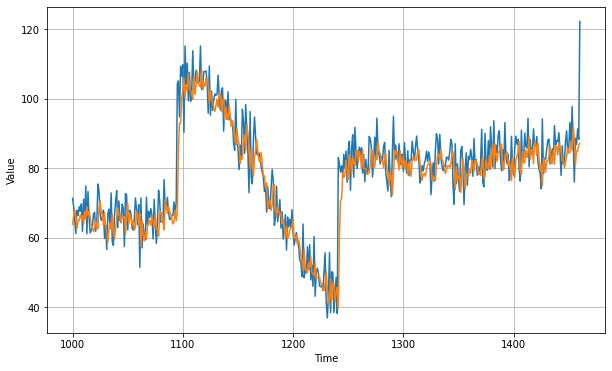

In [12]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid,results).numpy()

5.075305